# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.



In [1]:
#Connecting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#My content Path
file_path = "/content/DLL/Project_data"

In [0]:
import numpy as np
import os
import imageio 
import datetime
import os
from PIL import Image 

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
%tensorflow_version 1.x
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [0]:
#main parameters

train_doc = np.random.permutation(open(file_path+'/train.csv').readlines())
val_doc = np.random.permutation(open(file_path+'/val.csv').readlines())
batch_size = 60
resizing_width =224
resizing_height =224


In [377]:
import pandas as pd
dd=pd.DataFrame([i.split(";") for i in val_doc])
dd.columns =["File_name",'type','id']
print("Validation set")
display(dd.pivot_table(values='File_name', index='id', columns='type', 
                         aggfunc=lambda x: len(x.unique())))
dd=pd.DataFrame([i.split(";") for i in train_doc])
dd.columns =["File_name",'type','id']

print("Validation set")
display(dd.pivot_table(values='File_name', index='id', columns='type', 
                         aggfunc=lambda x: len(x.unique())))

Validation set


type,Left Swipe_new_Left Swipe_new,Left_Swipe_new,Right Swipe_new,Right_Swipe_new,Stop Gesture_new,Stop_new,Thumbs Down_new,Thumbs Up_new,Thumbs_Down_new,Thumbs_Up_new
id,,,,,,,,,,
0\n,5.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1\n,NaN,NaN,10.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
2\n,NaN,NaN,NaN,NaN,8.0,14.0,NaN,NaN,NaN,NaN
3\n,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,12.0,NaN
4\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,10.0


Validation set


type,Left Swipe_new_Left Swipe_new,Left_Swipe_new,Right Swipe_new,Right_Swipe_new,Stop Gesture_new,Stop_new,Thumbs Down_new,Thumbs Up_new,Thumbs_Down_new,Thumbs_Up_new
id,,,,,,,,,,
0\n,40.0,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1\n,NaN,NaN,34.0,103.0,NaN,NaN,NaN,NaN,NaN,NaN
2\n,NaN,NaN,NaN,NaN,37.0,93.0,NaN,NaN,NaN,NaN
3\n,NaN,NaN,NaN,NaN,NaN,NaN,37.0,NaN,100.0,NaN
4\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.0,NaN,87.0


In [85]:
int(len(train_doc)/batch_size)
#len(train_doc)

66

In [0]:
ls= list(np.arange(1,30,2))

len(ls)

15

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [0]:
#from keras.applications.vgg16 import preprocess_input

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #img_idx = list(np.arange(1,30,2))
    img_idx = [0,1,2,4,5,6,9,10,12,13,15,16,20,21,24,25,28,29]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        print(f"Number of batches {num_batches}")
        for batch in range(num_batches): # we iterate over the number of batches
            x= len(img_idx)           
            y=resizing_width
            z=resizing_height
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                #print(imgs)
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #print(folder + (batch*batch_size))
                    #print(imgs[item])
                    image=Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    #Croping and Resizing Logics logic based on % of broder getting eliminated 
                    # _width, _height = image.size 
                    # left = int((_width *0.05)/2)
                    # top =  int((_height *0.05)/2)
                    # right = _width -(left*2)
                    # bottom = _height -(top*2)
                    # image = image.crop((left, top, right, bottom)).resize((resizing_width,resizing_height),Image.ANTIALIAS)

                   # image = preprocess_input(image)

                    try:
                      from keras.preprocessing.image import img_to_array
                      image = image.resize((resizing_width,resizing_height),Image.NEAREST)
                      image = img_to_array(image)
                      from keras.applications.vgg16 import preprocess_input
                    # first batch
                      image = preprocess_input(image)
                      batch_data[folder,idx,:,:,0] = np.array(image).astype(float)[:,:,0]
                      batch_data[folder,idx,:,:,1] = np.array(image).astype(float)[:,:,1]
                      batch_data[folder,idx,:,:,2] = np.array(image).astype(float)[:,:,2]
                    except:
                      print("first "+source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])

                                        
                    # batch_data[folder,idx,:,:,0] = np.array(image).astype(float)[:,:,0]/255
                    # batch_data[folder,idx,:,:,1] = np.array(image).astype(float)[:,:,1]/255
                    # batch_data[folder,idx,:,:,2] = np.array(image).astype(float)[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches\
        if len(folder_list) >batch_size * num_batches:
            x=len(img_idx)
            start = (num_batches*batch_size)
            remaining = len(folder_list) - start        
            batch_data = np.zeros((remaining,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining,5)) # batch_labels is the one hot representation of the output
            #print(batch_data.shape)
            for folder in range(start,len(folder_list)): # iterate over the batch_size
              imgs = os.listdir(source_path+'/'+ t[folder].split(';')[0]) # read all the images in the folder
              for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                image=Image.open(source_path+'/'+ t[folder].strip().split(';')[0]+'/'+imgs[item])
                from keras.preprocessing.image import img_to_array
                image = image.resize((resizing_width,resizing_height),Image.NEAREST)
                image = img_to_array(image)
                    # last batch
                from keras.applications.vgg16 import preprocess_input
                image = preprocess_input(image)
                batch_data[folder-start,idx,:,:,0] = np.array(image).astype(float)[:,:,0]
                batch_data[folder-start,idx,:,:,1] = np.array(image).astype(float)[:,:,1]
                batch_data[folder-start,idx,:,:,2] = np.array(image).astype(float)[:,:,2]
                    
                    #Croping and Resizing Logics logic based on % of broder getting eliminated 
                    # _width, _height = image.size 
                    # left = int((_width *0.05)/2)
                    # top =  int((_height *0.05)/2)
                    # right = _width -(left*2)
                    # bottom = _height -(top*2)
                    # image = image.crop((left, top, right, bottom)).resize((resizing_width,resizing_height),Image.ANTIALIAS)

                    # #image = preprocess_input(image)
                                        
                    # batch_data[folder-start,idx,:,:,0] = np.array(image).astype(float)[:,:,0]/255
                    # batch_data[folder-start,idx,:,:,1] = np.array(image).astype(float)[:,:,1]/255
                    # batch_data[folder-start,idx,:,:,2] = np.array(image).astype(float)[:,:,2]/255
                    
              batch_labels[folder-start, int(t[folder-start].strip().split(';')[2])] = 1
        yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        
        

In [0]:
#%reset -f -s

# New Section

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [169]:
curr_dt_time = datetime.datetime.now()
train_path = file_path+'/train'
val_path = file_path+'/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

# Model -1 

Following Model is Developed with 3D convolution network design. in this design entire vedio is submited for convolution and extract necessessary features followed by the Fully connected dense layer to classify


In [176]:

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,LSTM,GlobalAveragePooling2D,Reshape
from keras.layers.convolutional import Conv3D,Conv2D, MaxPooling3D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2
import keras
#from mish import Mish

resizing_width=90
resizing_height=90

from keras import backend as K
def activation_function(inputs):
    return inputs * K.tanh(K.softplus(inputs))



model =Sequential()
num_classes=5

model.add(Conv3D(128, (2, 2, 2), padding='same', input_shape=(18,resizing_width,resizing_height,3)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2),strides=(1, 2, 2)))

model.add(Conv3D(256, (3, 3, 3), padding='same'))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2),strides=(1, 3, 3)))

model.add(Conv3D(128, (3,3,3), padding='same'))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(Dropout(.1))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2),strides=(1, 3, 3)))
model.add(Dropout(.1))

#reshare to sequence for Dense processing

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(.3))
model.add(Dense(5, activation='softmax'))


optimiser=keras.optimizers.Adamax(lr=0.0001, beta_1=0.3, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 18, 90, 90, 128)   3200      
_________________________________________________________________
activation_21 (Activation)   (None, 18, 90, 90, 128)   0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 18, 90, 90, 128)   512       
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 18, 45, 45, 128)   0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 18, 45, 45, 256)   884992    
_________________________________________________________________
activation_22 (Activation)   (None, 18, 45, 45, 256)   0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 18, 45, 45, 256) 

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [0]:
#training the model

batch_size =10
num_epochs = 30

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

#model call backs and history capturing
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10,min_delta=0.0001, cooldown=0, min_lr=0) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

#derive the batch and sequence optmization
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

## Model -1 Training


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [179]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
Source path =  /content/DLL/Project_data/train ; batch size = 10
Number of batches 66Source path = 
 /content/DLL/Project_data/val ; batch size = 10
Number of batches 10
67/67 [==============================] - 45s 672ms/step - loss: 2.5082 - categorical_accuracy: 0.2666 - val_loss: 1.3681 - val_categorical_accuracy: 0.4700

Epoch 00001: saving model to model_init_2020-02-2921_03_05.141901/model-00001-2.51530-0.26244-1.36811-0.47000.h5
Epoch 2/30
67/67 [==============================] - 35s 520ms/step - loss: 1.7702 - categorical_accuracy: 0.3512 - val_loss: 1.2707 - val_categorical_accuracy: 0.4800

Epoch 00002: saving model to model_init_2020-02-2921_03_05.141901/model-00002-1.76803-0.35143-1.27067-0.48000.h5
Epoch 3/30
67/67 [==============================] - 35s 520ms/step - loss: 1.5496 - categorical_accuracy: 0.3741 - val_loss: 1.2195 - val_categorical_accuracy: 0.4500

Epoch 00003: saving model to model_init_2020-02-2921_03_05.141901/model-00003-1.54828-0.37104-1.2195

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


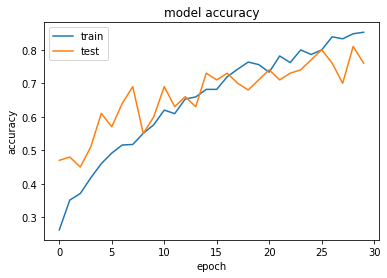

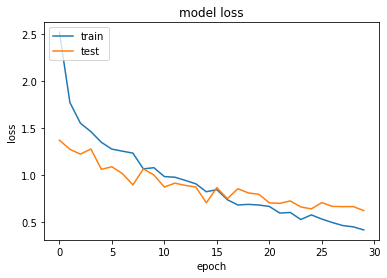

In [180]:
import matplotlib.pyplot as plt
%matplotlib inline

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# MODEL-2 

following Model is trained by

In [200]:
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras import regularizers

# base_model = ResNet50(weights='imagenet',  include_top=False)

resizing_width=224
resizing_height=224

vgg = VGG16(include_top=False, weights='imagenet',input_shape=(224, 224, 3))
for layer in vgg.layers[:-4]:
     layer.trainable = False

model = Sequential()
model.add(
    TimeDistributed(vgg, input_shape=(18, 224, 224, 3))
)

model.add(TimeDistributed(Flatten()))
model.add(GRU(100, activation='relu', recurrent_regularizer=regularizers.l2(0.01),return_sequences=False))
model.add(Dropout(.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(5, activation='softmax'))



optimiser=keras.optimizers.Adamax(lr=0.0001, beta_1=0.3, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_71 (TimeDis (None, 18, 7, 7, 512)     14714688  
_________________________________________________________________
time_distributed_72 (TimeDis (None, 18, 25088)         0         
_________________________________________________________________
gru_31 (GRU)                 (None, 100)               7556700   
_________________________________________________________________
dropout_94 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 128)               12928     
_________________________________________________________________
dropout_95 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_100 (Dense)            (None, 64)              

In [0]:
#training the model

batch_size =8
num_epochs = 45

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

#model call backs and history capturing
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10,min_delta=0.0001, cooldown=0, min_lr=0) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

#derive the batch and sequence optmization
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

## Model-2 Training



In [202]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/45
Source path =  /content/DLL/Project_data/val ; batch size =Source path =  /content/DLL/Project_data/train ; batch size = 8
 Number of batches 828

Number of batches 12
82/83 [============================>.] - ETA: 0s - loss: 5.5866 - categorical_accuracy: 0.1905Number of batches 82
Number of batches 12
83/83 [==============================] - 68s 822ms/step - loss: 5.5632 - categorical_accuracy: 0.1900 - val_loss: 2.7052 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2020-02-2921_03_05.141901/model-00001-5.56605-0.19005-2.70523-0.16000.h5
Epoch 2/45
82/83 [============================>.] - ETA: 0s - loss: 2.9814 - categorical_accuracy: 0.2226Number of batches 82
Number of batches 12
83/83 [==============================] - 53s 638ms/step - loss: 2.9763 - categorical_accuracy: 0.2216 - val_loss: 2.6432 - val_categorical_accuracy: 0.1800

Epoch 00002: saving model to model_init_2020-02-2921_03_05.141901/model-00002-2.97692-0.22172-2.64315-0.18000.h

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


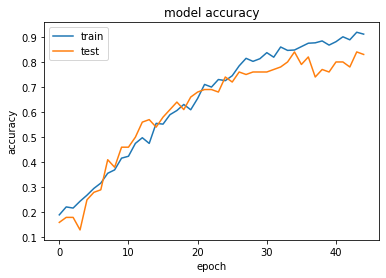

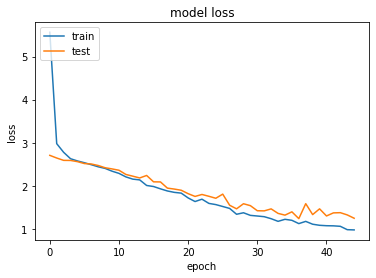

In [203]:
import matplotlib.pyplot as plt
%matplotlib inline

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [242]:

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,LSTM,GlobalAveragePooling2D,Reshape
from keras.layers.convolutional import Conv3D,Conv2D, MaxPooling3D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2

resizing_width=100
resizing_height=100

# #write your model here
model =Sequential()
num_classes=5
model.add(TimeDistributed(
            Conv2D(128, (2,2), padding='same', strides = 1),
            input_shape=(None, resizing_width, resizing_height, 3)))
model.add(TimeDistributed(Activation("relu")))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(512, (2, 2))))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Dropout(0.3)))

model.add(TimeDistributed(Conv2D(128, (2,2), padding='same')))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(3,3))))


# model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same')))
# model.add(TimeDistributed(Activation('relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D(pool_size=(3, 3))))

# model.add(TimeDistributed(Conv2D(128, (2, 2), padding='same')))
# model.add(TimeDistributed(Activation('relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
# model.add(TimeDistributed(Dropout(0.3)))


model.add(TimeDistributed(Flatten()))

#model.add(Dense(512,activation="relu"))

model.add(TimeDistributed(Dense(512,activation="relu",kernel_regularizer=l2(0.01))))
model.add(TimeDistributed(Dropout(0.2)))
# model.add(TimeDistributed(Dense(256,activation="relu",kernel_regularizer=l2(0.01))))
# model.add(TimeDistributed(Dropout(0.3)))
# model.add(TimeDistributed(Dense(128,activation="relu",kernel_regularizer=l2(0.01))))
# model.add(TimeDistributed(Dropout(0.3)))

model.add(GRU(100, return_sequences = False))

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(64,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(32,activation="relu"))

model.add(Dense(num_classes))
model.add(Activation('softmax'))


optimiser=keras.optimizers.Adamax(lr=0.0001, beta_1=0.3, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_232 (TimeDi (None, None, 100, 100, 12 1664      
_________________________________________________________________
time_distributed_233 (TimeDi (None, None, 100, 100, 12 0         
_________________________________________________________________
time_distributed_234 (TimeDi (None, None, 100, 100, 12 512       
_________________________________________________________________
time_distributed_235 (TimeDi (None, None, 50, 50, 128) 0         
_________________________________________________________________
time_distributed_236 (TimeDi (None, None, 49, 49, 512) 262656    
_________________________________________________________________
time_distributed_237 (TimeDi (None, None, 49, 49, 512) 0         
_________________________________________________________________
time_distributed_238 (TimeDi (None, None, 49, 49, 512

In [0]:
#training the model

batch_size =5
num_epochs = 35

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

#model call backs and history capturing
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10,min_delta=0.0001, cooldown=0, min_lr=0) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

#derive the batch and sequence optmization
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [244]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/35
Source path =  /content/DLL/Project_data/val Source path = ; batch size =  /content/DLL/Project_data/train5 
; batch size =Number of batches 20 
5
Number of batches 132
133/133 [==============================] - 41s 309ms/step - loss: 10.9586 - categorical_accuracy: 0.2236 - val_loss: 10.6944 - val_categorical_accuracy: 0.3700

Epoch 00001: saving model to model_init_2020-02-2921_03_05.141901/model-00001-10.95906-0.22323-10.69436-0.37000.h5
Epoch 2/35
133/133 [==============================] - 29s 218ms/step - loss: 10.5462 - categorical_accuracy: 0.2436 - val_loss: 10.3269 - val_categorical_accuracy: 0.3700

Epoch 00002: saving model to model_init_2020-02-2921_03_05.141901/model-00002-10.54653-0.24434-10.32692-0.37000.h5
Epoch 3/35
Number of batches 20
133/133 [==============================] - 30s 225ms/step - loss: 10.2202 - categorical_accuracy: 0.2386 - val_loss: 9.9474 - val_categorical_accuracy: 0.5500

Epoch 00003: saving model to model_init_2020-02-2921_03_05.141901

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


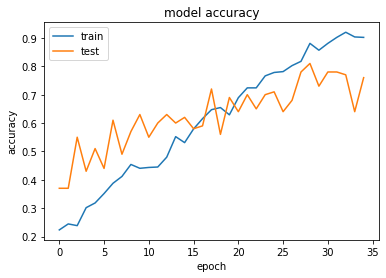

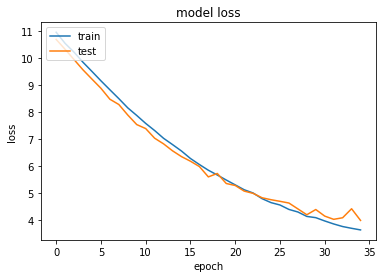

In [246]:
import matplotlib.pyplot as plt
%matplotlib inline

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [363]:

resizing_width=100
resizing_height=100


model = Sequential()
model.add 
model.add(ConvLSTM2D(filters=100, kernel_size=(1,3), activation='relu', input_shape=(18, resizing_width, resizing_height, 3),return_sequences=True))
model.add(ConvLSTM2D(filters=50, kernel_size=(1,3), activation='relu',return_sequences=True))
model.add(ConvLSTM2D(filters=34, kernel_size=(1,3), activation='relu'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(5, activation='softmax'))



optimiser=keras.optimizers.Adamax(lr=0.0001, beta_1=0.3, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_146"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_127 (ConvLSTM2D (None, 18, 100, 98, 100)  124000    
_________________________________________________________________
conv_lst_m2d_128 (ConvLSTM2D (None, 18, 100, 96, 50)   90200     
_________________________________________________________________
conv_lst_m2d_129 (ConvLSTM2D (None, 100, 94, 34)       34408     
_________________________________________________________________
dropout_206 (Dropout)        (None, 100, 94, 34)       0         
_________________________________________________________________
flatten_83 (Flatten)         (None, 319600)            0         
_________________________________________________________________
dense_251 (Dense)            (None, 100)               31960100  
_________________________________________________________________
dense_252 (Dense)            (None, 5)              

In [0]:
#training the model

batch_size =10
num_epochs = 35

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

#model call backs and history capturing
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10,min_delta=0.0001, cooldown=0, min_lr=0) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

#derive the batch and sequence optmization
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [365]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/35
Source path = Source path =   /content/DLL/Project_data/train/content/DLL/Project_data/val  ; batch size =; batch size = 10
 Number of batches 1010

Number of batches 66


InternalError: ignored

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
rm -r /content/model_init_2020-02-2921_03_05.141901

In [0]:
!unzip -qq "/content/drive/My Drive/DL/Project_data.zip" -d /content/DLL/

In [0]:
cp -r  "model_init_2020-02-2921_03_05.141901/model-00029-0.44612-0.84766-0.66170-0.81000.h5" "/content/drive/My Drive/DL/CNN3D/"

In [0]:
from keras.models import load_model

model1 = load_model('/content/drive/My Drive/DL/CNN3D/model-00027-0.57744-0.78884-0.80990-0.76000.h5')

In [0]:
im = Image.open("/content/DLL/Project_data/val/WIN_20180926_17_09_33_Pro_Left_Swipe_new/WIN_20180926_17_09_33_Pro_00029.png")

In [115]:
val_doc.shape

(100,)